In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


sns.set_style('whitegrid')
dir_enigh_2020 = 'datos/enigh_2020'
dir_tablas = 'datos/tablas_regresiones'

print('Python', sys.version)
for lb in [pd, np, sns, plt.matplotlib]:
    print(lb.__name__, lb.__version__)

Python 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
pandas 1.2.4
numpy 1.20.1
seaborn 0.11.1
matplotlib 3.3.4


In [5]:
efectos_0 = pd.read_html(f'{dir_tablas}/efectos_marginales_enigh_2020.html', header=[2, 3], thousands='')[0]
lista_estimados = efectos_0.columns.levels[1][1].split('/')
efectos = efectos_0.droplevel(1, axis=1)\
    .rename(columns={'Unnamed: 0_level_0': 'variable'})\
    .assign(variable=lambda x: x['variable'].ffill())\
    .query("variable!='Observations'")\
    .loc[lambda x: x.filter(like='mod').notnull().any(axis=1)]\
    .assign(estimado=lambda x: lista_estimados * (x.shape[0]//len(lista_estimados)))\
    .set_index(['variable', 'estimado'])\
    .stack().unstack('estimado')\
    .assign(
        ci_l=lambda x: x['ci95'].str.split(',').str[0].astype(float),
        ci_u=lambda x: x['ci95'].str.split(',').str[1].astype(float),
        b=lambda x: x['b'].str.replace('*', '', regex=False).astype(float)
    )\
    .rename_axis(index=['variable', 'modelo'])\
    .swaplevel('modelo', 'variable')\
    .loc['modelo_1']
efectos.head()

estimado,b,ci95,p,se,t,ci_l,ci_u
variable,,,,,,,
"100,000 y más habitantes",0.0216,"0.0032,0.0400",0.0214,0.0094,2.3014,0.0032,0.0400
"15,000 a 99,999 habitantes",0.0080,"-0.0106,0.0266",0.4003,0.0095,0.8411,-0.0106,0.0266
"2,500 a 14,999 habitantes",-0.0032,"-0.0212,0.0148",0.7289,0.0092,-0.3466,-0.0212,0.0148
2001-4000,0.0021,"-0.0108,0.0150",0.7479,0.0066,0.3215,-0.0108,0.0150
4001-6000,0.0188,"0.0028,0.0349",0.0213,0.0082,2.3029,0.0028,0.0349


In [66]:
dicc_nombre_coef = {
    '100,000 y más habitantes': 'Localidad # >100 mil hab',
    '15,000 a 99,999 habitantes': 'Localidad # 15-99.9 mil hab',
    '2,500 a 14,999 habitantes': 'Localidad # 2.5-14.9 mil hab',
    '2001-4000': 'Ingreso mensual # 2-4 mil pesos',
    '4001-6000': 'Ingreso mensual # 4-6 mil pesos',
    '6001-8000': 'Ingreso mensual # 6-8 mil pesos',
    '8000 o más': 'Ingreso mensual # >8 mil pesos',
    'Alto': 'Estatus socioec. # Alto',
    'Medio alto': 'Estatus socioec. # Medio alto',
    'Medio bajo': 'Estatus socioec. # Medio bajo',
    'Servicios': 'Sector # Servicios',
    'Industrial': 'Sector # Industrial',
    'Maestría o doctorado': 'Educación # Maestría/doctorado',
    'Normal o técnica': 'Educación # Normal/técnica',
    'Profesional': 'Educación # profesional',
    'Secundaria o preparatoria': 'Educación # Secundaria/prepa',
    'edad': 'Edad',
    'mujer': 'Sexo # Mujer',
    'tiene_celular': 'Tiene celular',
    'tiene_contabilidad': 'Hace contabilidad',
    'tiene_empleados': 'Tiene empleados',
    'tiene_internet': 'Tiene internet en el hogar'
}


orden_coef = ['100,000 y más habitantes', '15,000 a 99,999 habitantes', '2,500 a 14,999 habitantes', '2001-4000', '4001-6000', '6001-8000', '8000 o más', 'Alto', 'Medio alto', 'Medio bajo', 'Servicios', 'Industrial', 'tiene_contabilidad', 'tiene_internet', 'tiene_empleados', 'Maestría o doctorado',  'Profesional', 'Normal o técnica', 'Secundaria o preparatoria', 'mujer', 'tiene_celular']

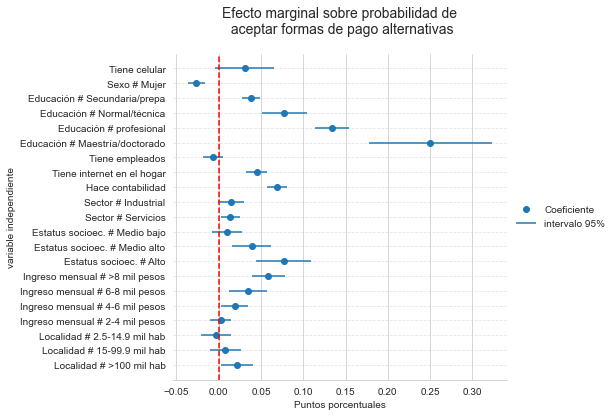

In [67]:
ax = plt.subplot()
ax.figure.set_size_inches(6, 6)
modelo_1 = efectos.loc[orden_coef].assign(n=lambda x: range(x.shape[0])).sort_values('n', False)
ax.plot(modelo_1['b'], modelo_1['n'], 'o', color='C0', label='Coeficiente')

ax.hlines(y=modelo_1['n'], xmin=modelo_1['ci_l'], xmax=modelo_1['ci_u'], color='C0', label='intervalo 95%')

sns.despine(left=True)
ax.set_yticks(list(range(len(dicc_nombre_coef)-1)))
ax.set_yticklabels([dicc_nombre_coef.get(x) for x in orden_coef])
ax.yaxis.grid(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

ax.set_title('Efecto marginal sobre probabilidad de\n aceptar formas de pago alternativas', pad=20, size=14)
ax.set_ylabel('variable independiente')
ax.set_xlabel('Puntos porcentuales')
ax.axvline(x=0, ls='--', color='red')
ax.yaxis.grid(True, ls='--', alpha=0.5)
ax.figure.savefig('graficas/08_efectos_marginales_modelo.png', dpi=600, bbox_inches='tight')